In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import probplot
import math

In [3]:
DATA_DIR = 'data'
INPUT_DIR = 'input'
OUTPUT_DIR = 'output'
INPUT_PATH = f'{DATA_DIR}/{INPUT_DIR}'
OUTPUT_PATH = f'{DATA_DIR}/{OUTPUT_DIR}'

# Reading Data and Cleaning

## Data Source and Description

The dataset is obtained from the Wharton Research Data Services (WRDS), a comprehensive online platform that provides access to various financial, economic, and marketing databases. The data comprises pre-calculated financial ratios for industries within the US economy.

The dataset includes a wide range of ratios categorized into different sections, such as:

### Valuation Ratios
- Price-to-Earnings (P/E) ratios: PEG_1yrforward, PEG_ltgforward, PEG_trailing, CAPEI, etc.
- Price-to-Book (P/B) ratios: bm, ptb
- Enterprise Value Multiple (evm)
- Price-to-Sales (ps)
- Price-to-Cash Flow (pcf)

### Profitability Ratios
- Gross Profit Margin (gpm)
- Net Profit Margin (npm)
- Operating Profit Margins: opmad, opmbd
- Return on Assets (roa)
- Return on Equity (roe)
- Return on Capital Employed (roce)

### Leverage and Coverage Ratios
- Debt-to-Equity (de_ratio)
- Debt-to-Assets (debt_assets, debt_at)
- Interest Coverage (intcov, intcov_ratio)

### Liquidity Ratios
- Current Ratio (curr_ratio)
- Quick Ratio (quick_ratio)
- Cash Ratio (cash_ratio)

### Efficiency Ratios
- Asset Turnover (at_turn)
- Inventory Turnover (inv_turn)
- Receivables Turnover (rect_turn)

The dataset also includes industry-level returns, both equal-weighted (indret_ew) and value-weighted (indret_vw), as well as the number of firms (nfirm) within each industry classification.

### Time Series
Data has the data in a Month-over-Month (MoM) format

To mitigate the influence of outliers, the median value is chosen as the aggregation method for each ratio, rather than the mean. This approach ensures that the data is more representative of the typical firm within an industry, as the median is less sensitive to extreme values.

**Note:** All mentions of Industry in the WRDS data, would be considered equal to Sector in GICS context.

# GICS
For industries we follow the GICS standard.

![GICS Hierarchy](misc/images/gics_hierarchy.png)

The GICS have multiple levels of complexity. However, we focus on Sector level [justify with papers of hierarchical forecasting]



In [4]:
pd.read_csv(f'{INPUT_PATH}/sectoral_fundamentals_explanation.csv')

Variable Name   Type                                        Description
0        indret_ew   Char                     Equal Weighted Industry Return
1        indret_vw   Char                     Value Weighted Industry Return
2            nfirm   Char  The number of companies that belongs to the in...
3   PEG_1yrforward  Float  Forward P/E to 1-year Growth (PEG) ratio (peg_...
4            CAPEI  Float     Shillers Cyclically Adjusted P/E Ratio (capei)
..             ...    ...                                                ...
69        sale_nwc  Float                   Sales/Working Capital (sale_nwc)
70         Accrual  Float                  Accruals/Average Assets (accrual)
71         RD_SALE  Float           Research and Development/Sales (rd_sale)
72        adv_sale  Float               Avertising Expenses/Sales (adv_sale)
73      staff_sale  Float                  Labor Expenses/Sales (staff_sale)

[74 rows x 3 columns]

In [5]:
df = pd.read_csv(f'{INPUT_PATH}/sectoral_fundamentals.csv')
sector_column = 'gicdesc'
date_column = 'public_date'
df[date_column] = pd.to_datetime(df[date_column])
df = df.set_index([sector_column, date_column])

In [6]:
percent_cols = [col for col in df.columns if df[col].dtype == "object" and df[col].str.contains('%').any()]
for col in percent_cols:
    df[col] = df[col].str.rstrip('%').astype('float') / 100

In [7]:
df.isna().sum().sort_values(ascending=False)
# TODO: Handle NULLs (e.g. interpolate)

PEG_ltgforward_Median    68
PEG_1yrforward_Median    54
NFIRM                     0
debt_ebitda_Median        0
debt_assets_Median        0
                         ..
opmad_Median              0
npm_Median                0
gpm_Median                0
aftret_invcapx_Median     0
staff_sale_Median         0
Length: 74, dtype: int64

# Let's Analyse Correlations

In [13]:
target_columns = ['indret_ew'] #, 'indret_vw'
drop_columns = [x for x in ['indret_ew', 'indret_vw'] if x not in target_columns]
sector = 'Energy'
if sector:
    df = df.reset_index().loc[df.reset_index()['gicdesc'] == sector].set_index(df.index.names)
df = df.drop(drop_columns, axis=1)
corr_all = df.corr()[target_columns].drop(target_columns, errors='ignore')

In [14]:
display(corr_all)

indret_ew
NFIRM                  -0.141749
PEG_1yrforward_Median   0.052449
CAPEI_Median           -0.065932
bm_Median               0.105356
PEG_ltgforward_Median  -0.001673
...                          ...
sale_nwc_Median        -0.111231
accrual_Median         -0.126818
rd_sale_Median               NaN
adv_sale_Median              NaN
staff_sale_Median            NaN

[72 rows x 1 columns]

## Correlation All Sectors
Quite insignificant, what about per sector?

In [15]:
grouped = df.groupby(sector_column)

group_correlations = {}
for name, group in grouped:
    corr = group.corr()
    corr = corr.drop(target_columns, errors='ignore')
    group_correlations[name] = corr[target_columns]

In [16]:
for name, corr in group_correlations.items():
    print(f"Correlation data for {name}:")
    display(corr[abs(corr) > 0.07].dropna(how='all', axis=1).dropna(how='all', axis=0))

Correlation data for Energy:


indret_ew
NFIRM                  -0.141749
bm_Median               0.105356
evm_Median             -0.136034
pe_exi_Median          -0.078840
pe_inc_Median          -0.076656
ps_Median               0.127039
pcf_Median              0.163096
dpr_Median              0.148413
ptb_Median              0.211648
divyield_Median        -0.098413
GProf_Median           -0.098125
aftret_eq_Median       -0.149815
aftret_equity_Median   -0.153001
aftret_invcapx_Median  -0.142482
gpm_Median             -0.117835
npm_Median             -0.128079
opmad_Median           -0.120125
opmbd_Median           -0.154242
pretret_earnat_Median  -0.111461
pretret_noa_Median     -0.104087
ptpm_Median            -0.124840
roa_Median             -0.134536
roce_Median            -0.119922
roe_Median             -0.143904
invt_act_Median         0.166258
rect_act_Median        -0.098148
fcf_ocf_Median          0.148952
ocf_lct_Median         -0.159847
cfm_Median             -0.160684
short_debt_Median       0.149817
profit_lct_Median      -0.153807
debt_ebitda_Median     -0.160864
int_totdebt_Median     -0.106095
lt_ppent_Median         0.160796
de_ratio_Median        -0.107514
intcov_Median          -0.162642
intcov_ratio_Median    -0.144633
curr_ratio_Median       0.090804
quick_ratio_Median      0.098280
inv_turn_Median        -0.100900
pay_turn_Median         0.132482
sale_nwc_Median        -0.111231
accrual_Median         -0.126818

## What do these correlations say?
We already can see discrepancies on the relevance of certain parameters in different Sectors.

# Distributions

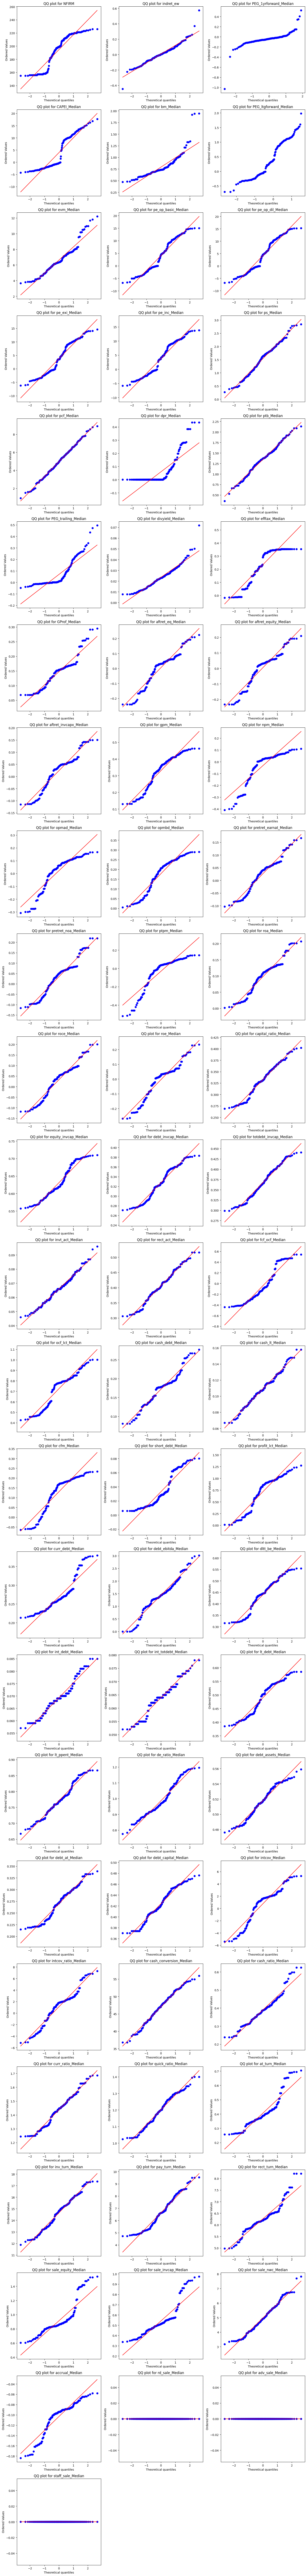

In [17]:
n = len(df.columns)
ncols = 3
nrows = n // ncols if n % ncols == 0 else n // ncols + 1


fig, axs = plt.subplots(nrows, ncols, figsize=(15, nrows*5))
axs = axs.flatten()

for i, column in enumerate(df.columns):
    probplot(df[column], plot=axs[i])
    axs[i].set_title(f'QQ plot for {column}')

for i in range(n, nrows*ncols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

## Results

In most cases data seems to follow a standard distributions. 
**TODO:** Further analysis needed per Sector. Also, analyse if there is any data transformation that would benefit

# Correlation (Scatter Plots)

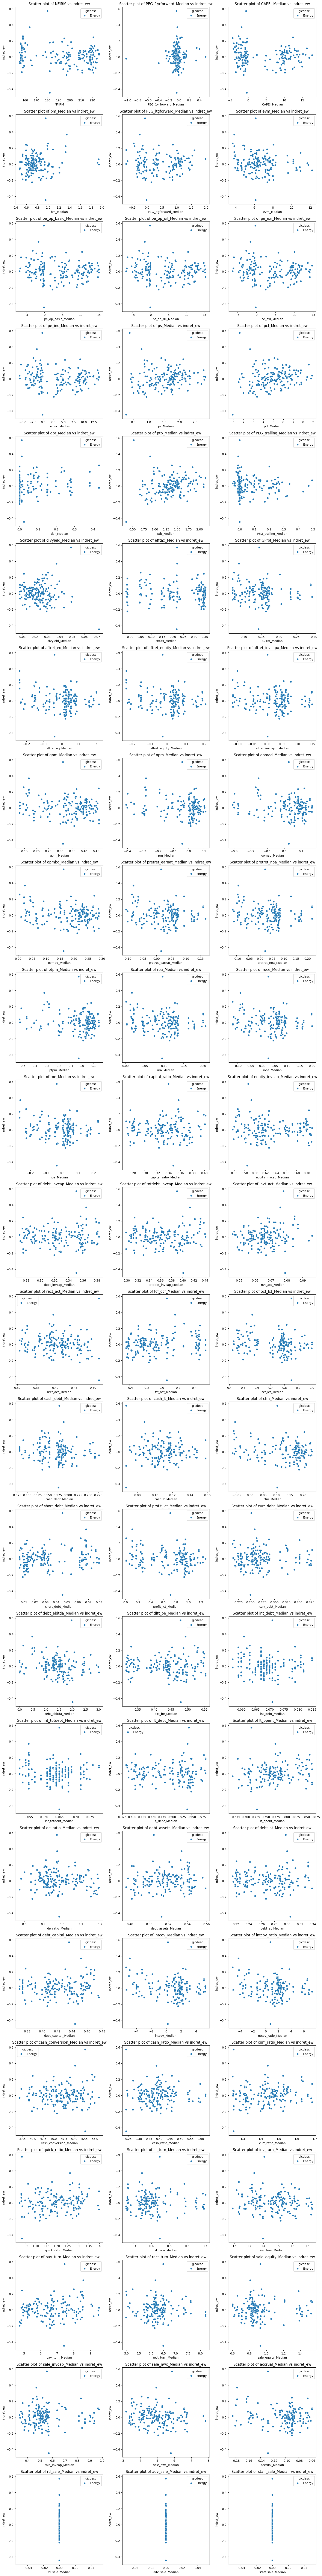

In [18]:
parameters = [x for x in df.columns if x not in target_columns]

n = len(parameters) * len(target_columns)
ncols = 3
nrows = n // ncols if n % ncols == 0 else n // ncols + 1

fig, axs = plt.subplots(nrows, ncols, figsize=(15, nrows*5))
axs = axs.flatten()

for i, (parameter, target) in enumerate([(p, t) for p in parameters for t in target_columns]):
    sns.scatterplot(data=df.reset_index(), x=parameter, y=target, hue=sector_column, ax=axs[i])
    axs[i].set_title(f'Scatter plot of {parameter} vs {target}')

for i in range(n, nrows*ncols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

## Results
**TODO:** More Analysis Required. No claims for now. Also look at lagged correlations.

# Time Series Decomposition

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

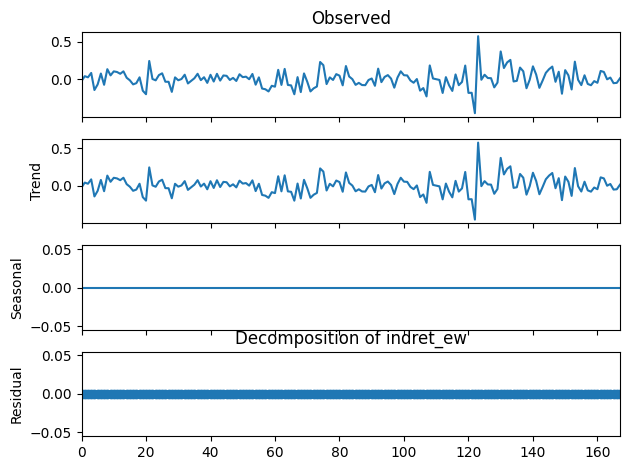

<Figure size 1000x500 with 0 Axes>

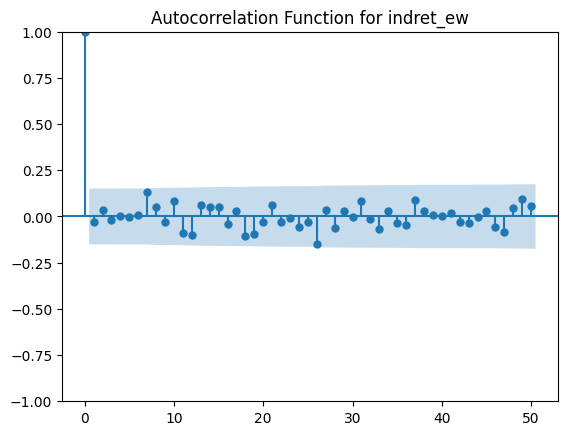

In [20]:
for target in target_columns:
    result = seasonal_decompose(df[target].values, model='additive', period=1)

    result.plot()
    plt.title('Decomposition of ' + target)
    
    plt.figure(figsize=(10,5))
    plot_acf(df[target].values, lags=50)
    plt.title('Autocorrelation Function for ' + target)
    
    plt.show()

Decomposition of indret_ew for Energy


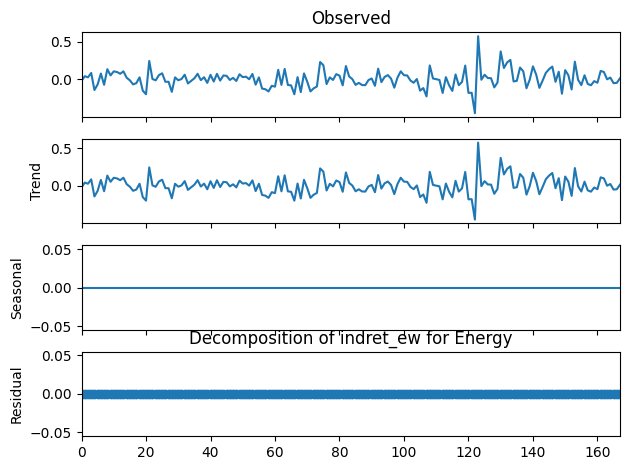

<Figure size 1000x500 with 0 Axes>

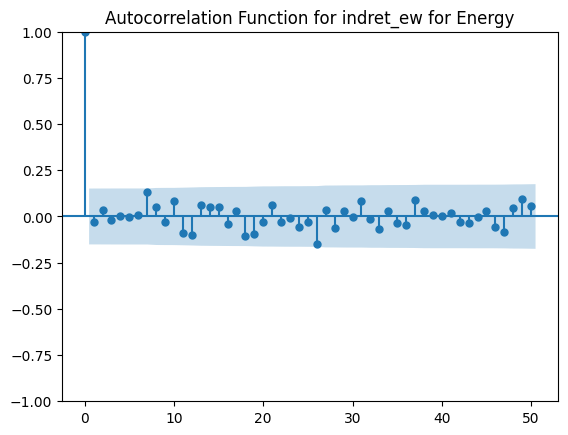

In [21]:
grouped = df.groupby(sector_column)

for sector, group in grouped:
    for target in target_columns:
        print(f"Decomposition of {target} for {sector}")
        result = seasonal_decompose(group[target].dropna().values, model='additive', period=1)

        result.plot()
        plt.title('Decomposition of ' + target + ' for ' + sector)
        
        plt.figure(figsize=(10,5))
        plot_acf(group[target].dropna(), lags=50)
        plt.title('Autocorrelation Function for ' + target + ' for ' + sector)
        
        plt.show()

## Result
More steps needed for claims as of now. However, seems to be autocorrelation, at least partial.

# Basic Models

In [22]:
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

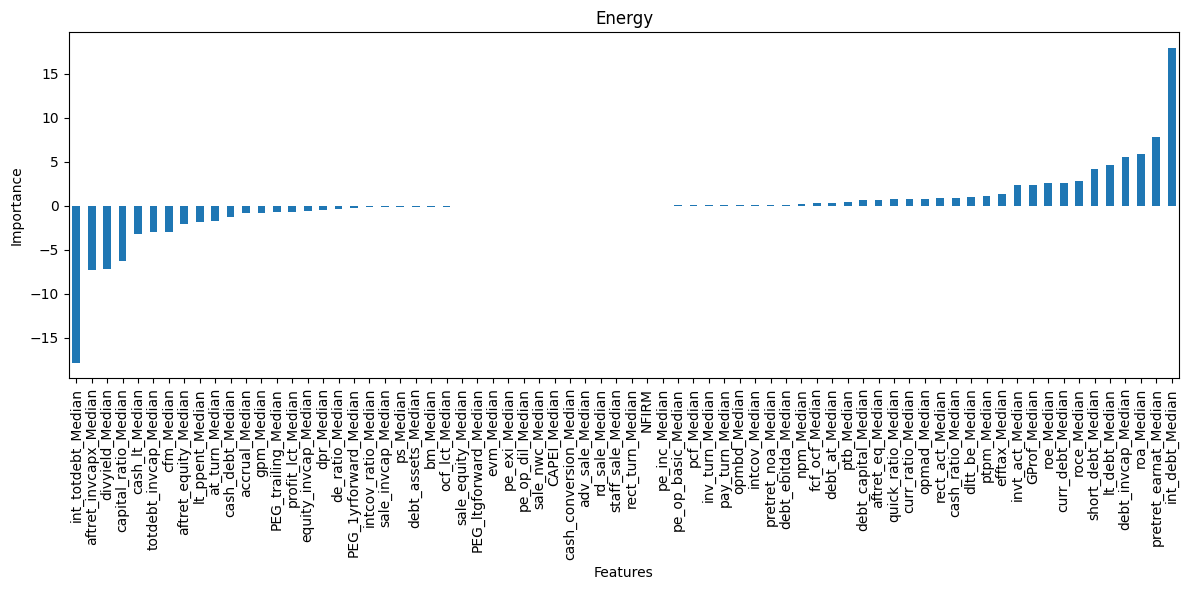

In [29]:
grouped = df.groupby(sector_column)
target_column = target_columns[0]

feature_importances = []

for name, group in grouped:
    X = group.drop([target_column], axis=1).ffill()
    y = group[target_column]

    model = LinearRegression()

    model.fit(X, y)

    importance = model.coef_
    feature_importances.append(importance)

# Convert the list to a DataFrame
feature_importances_df = pd.DataFrame(feature_importances, columns=X.columns, index=grouped.groups.keys())
feature_importances_df = feature_importances_df.reset_index().rename(columns={'index': 'Sector'})

n_sectors = feature_importances_df['Sector'].nunique()

if n_sectors == 1:
    fig, axes = plt.subplots(figsize=(12, 6))
    flat_axes = np.array([axes])
else:
    fig, axes = plt.subplots(nrows=n_sectors, figsize=(12, 6*n_sectors))
    flat_axes = axes.flatten()

# Iterate over sectors and create a bar plot for each one
for (sector, data), ax in zip(feature_importances_df.melt(id_vars='Sector').groupby('Sector'), flat_axes):
    data = data.sort_values(by='value')
    data.plot(x='variable', y='value', kind='bar', ax=ax, legend=False)
    ax.set_title(sector)
    ax.set_xlabel('Features')
    ax.set_ylabel('Importance')

plt.tight_layout()
plt.show()

## Result:
The feature importance will help to further the analysis process. For now, some features seem to be consistent across sectors, while others are more variable between them.

In [18]:
# feature_columns = [col for col in df.columns if col not in target_columns + [sector_column]]

# scores = {}
# grouped = df.groupby(sector_column)

# for sector, group in grouped:
#     for target in target_columns:
#         # Fit the ARIMA model
#         arima_model = ARIMA(group[target].dropna(), order=(1, 1, 1))
#         arima_result = arima_model.fit()

#         # Fit the GARCH model
#         garch_model = arch_model(arima_result.resid, vol='Garch', p=1, q=1)
#         garch_result = garch_model.fit(disp='off')

#         # Print the summary of the GARCH model
#         print(f'GARCH Model for {target} in {sector}:\n')
#         print(garch_result.summary())

In [19]:
# scores = []
# grouped = df.groupby(sector_column)

# for sector, group in grouped:
#     for target in target_columns:
#         # Split the data into training and testing sets
#         train = group[target].dropna()[:-10]
#         test = group[target].dropna()[-10:]

#         # Fit the ARIMA model
#         arima_model = ARIMA(train, order=(1, 1, 1))
#         arima_result = arima_model.fit()

#         # Make predictions
#         arima_pred = arima_result.predict(start=len(train), end=len(train)+len(test)-1)

#         # Fit the GARCH model
#         garch_model = arch_model(arima_result.resid, vol='Garch', p=1, q=1)
#         garch_result = garch_model.fit(disp='off')

#         # Make predictions
#         garch_pred = garch_result.forecast(start=0, horizon=len(test)).variance[-1:].values[0]

#         # Calculate the RMSE
#         arima_rmse = mean_squared_error(test, arima_pred, squared=False)
#         garch_rmse = mean_squared_error(test, garch_pred, squared=False)

#         # Append the scores
#         scores.append([sector, target, 'ARIMA', arima_rmse])
#         scores.append([sector, target, 'GARCH', garch_rmse])

#        # Plot the predictions and actual values
#         plt.figure(figsize=(10, 6))
#         plt.plot(test.index.get_level_values(1), test, label='Actual')
#         plt.plot(test.index.get_level_values(1), arima_pred, label='ARIMA Predictions')
#         plt.plot(test.index.get_level_values(1), garch_pred, label='GARCH Predictions')
#         plt.legend()
#         plt.title(f'{sector} - {target}')
#         plt.show()
#         break

# scores_df = pd.DataFrame(scores, columns=['Sector', 'Target', 'Model', 'Score'])
# display(scores_df)